# Estimating Rewards for GEM Environments

Our aim is to carry out RL tasks when rewards are delayed (aggregate, and anonymous), using linear function approximation.
To solve this problem, we aim to project both large discrete states and continuous states into basis vectors.


In this notebook, we explore state representation approaches to estimate rewards for [GEM environments](https://github.com/upb-lea/gym-electric-motor).
These environments have continuous states and discrete actions (there are continuous actions options as well, which are outside of scope).

The states rewards are a linear function of $(s,s')$. As such, we change the buffer from earlier notebooks from $(s,a,r)$ to $(s,a,s',r)$.

The test the following techniques:

  - Raw
  - Scaled (0 to 1)  
  - Gaussian
  - Tiling

In [1]:
import copy
import functools
import itertools
import math
from typing import Any, Optional

In [2]:
import gym_electric_motor as gem
import gymnasium as gym
import numpy as np
import pandas as pd
from gym_electric_motor import reward_functions
from sklearn import mixture, model_selection

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

## Feature Encoding

### Tiling Utils

In [4]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count(self):
        return len(self.dictionary)
    
    def fullp(self):
        return len(self.dictionary) >= self.size
    
    def getindex(self, obj, readonly=False):
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif readonly:
            return None
        size = self.size
        count = self.count()
        if count >= size:
            # TODO: Fail
            if self.overfullCount==0: 
                print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if isinstance(m, IHT):
        return m.getindex(tuple(coordinates), readonly)
    if isinstance(m, int):
        return basehash(tuple(coordinates)) % m
    if m is None:
        return coordinates


def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [math.floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [math.floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in itertools.zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles



In [5]:
def pow2geq(lb):
    exp = 1
    while True:
        rs = np.power(2, exp)
        if rs >= lb:
            break
        exp += 1
    return rs

In [6]:
class Tiles:
    def __init__(
        self, dims_min: np.ndarray, dims_max: np.ndarray, 
        tiling_dim: int, num_tilings: Optional[int] = None
    ):
        assert isinstance(dims_min, np.ndarray)
        assert isinstance(dims_max, np.ndarray)
        self.dims_max = dims_max
        self.dims_min = dims_min
        self.tiling_dim = tiling_dim
        self.wrapwidths = [tiling_dim] * np.size(dims_min)
    
        # num tilings should a power of 2
        # and at least 4 times greater than
        # the number of dimensions
        self.num_tilings = num_tilings or pow2geq(np.size(dims_min) * 4)
        self.max_size = (tiling_dim ** np.size(dims_min)) * self.num_tilings
        print("Num tilings", self.num_tilings, "\n", "Flat dim:", self.max_size)
        self.iht = IHT(self.max_size)

    def __call__(self, xs):
        xs_scaled_01 = (xs - self.dims_min) / (self.dims_max - self.dims_min)
        repr = np.zeros(shape=self.max_size)
        idx = tileswrap(
            self.iht, 
            self.num_tilings, 
            xs_scaled_01 * self.tiling_dim,
            self.wrapwidths
        )
        repr[idx] = 1
        return repr    

In [7]:
def delay_reward_data(buffer, delay: int, sample_size: int):
    action = np.stack([example[1] for example in buffer])
    reward = np.stack([example[3] for example in buffer])
    states = np.concatenate([
        np.stack([example[0] for example in buffer]), 
        np.stack([example[2] for example in buffer])], axis=1)


    # repr: (m1,a1)(m2,a1)..
    obs_dim = math.floor(states.shape[1] / 2)
    mdim = obs_dim * len(np.unique(action)) + obs_dim
    
    # build samples
    mask = np.random.choice(states.shape[0], (sample_size, delay))
    delayed_obs = states[mask]  # batch x delay x dim
    delayed_act = action[mask]
    delayed_rew = np.sum(reward[mask], axis=1)  # batch x delay -> batch

    rhat_matrix = np.zeros(shape=(sample_size, mdim))

    # TODO: use pandas to speed this up
    for i, (states, action) in enumerate(zip(delayed_obs, delayed_act)):
        for j in range(delay):
            obs, next_obs = states[j][:obs_dim], states[j][obs_dim:]
            c = obs_dim * action[j]
            rhat_matrix[i, c : c + obs_dim] += obs
            rhat_matrix[i, -obs_dim:] += next_obs

    return rhat_matrix, delayed_rew

In [8]:
def proj_obs_to_rwest_vec(buffer, sample_size: int):
    action = np.stack([example[1] for example in buffer])
    reward = np.stack([example[3] for example in buffer])
    states = np.concatenate([
        np.stack([example[0] for example in buffer]), 
        np.stack([example[2] for example in buffer])], axis=1)

    # repr: (m1,a1)(m2,a1)..
    obs_dim = math.floor(states.shape[1] / 2)
    mdim = obs_dim * len(np.unique(action)) + obs_dim
    

    # build samples
    mask = np.random.choice(states.shape[0], sample_size)
    delayed_obs = states[mask]  # batch x dim
    delayed_act = action[mask]
    delayed_rew = reward[mask]  # batch x delay -> batch

    rhat_matrix = np.zeros(shape=(len(delayed_obs), mdim))

    # TODO: use pandas to speed this up
    for i, (states, action) in enumerate(zip(delayed_obs, delayed_act)):
        obs, next_obs = states[:obs_dim], states[obs_dim:]
        c = obs_dim * action
        rhat_matrix[i, c : c + obs_dim] += obs
        rhat_matrix[i, -obs_dim:] += next_obs

    return rhat_matrix, delayed_rew

## Reward Estimation

In [9]:
def solve_least_squares(matrix: np.ndarray, rhs: np.ndarray) -> np.ndarray:
    try:
        solution, _, _, _ = np.linalg.lstsq(a=matrix, b=rhs, rcond=None)
        return solution  # type: ignore
    except np.linalg.LinAlgError as err:
        # the computation failed, likely due to the matix being unsuitable (no solution).
        raise ValueError("Failed to solve linear system") from err

In [10]:
def rmse(v_pred: np.ndarray, v_true: np.ndarray, axis: int):
    if np.shape(v_pred) != np.shape(v_true):
        raise ValueError(
            f"Tensors have different shapes: {np.shape(v_pred)} != {np.shape(v_true)}"
        )
    delta = v_pred - v_true
    sq = delta * delta  # np.power(delta, 2)
    sqsum = np.sum(sq, axis=axis) / np.shape(v_pred)[axis]
    sqsqrt = np.sqrt(sqsum)
    return sqsqrt

In [11]:
def collection_traj_data(env: gym.Env, steps: int):
    obs, _ = env.reset()
    step = 0
    buffer = []
    while step < steps:
        action = env.action_space.sample()
        (
            next_obs,
            rew,
            term,
            trunc,
            _,
        ) = env.step(action)
        step += 1
        buffer.append((obs, action, next_obs, rew))
        obs = next_obs
        if term or trunc:
            obs, _ = env.reset()
    return buffer

In [12]:
def solve_rwe(env: gym.Env, num_steps: int, sample_size: int, delay: int):
    buffer = collection_traj_data(env, steps=num_steps)
    Xd, yd = delay_reward_data(buffer, delay=delay, sample_size=sample_size)
    return buffer, solve_least_squares(Xd, yd)

In [13]:
def rwe_scatterplot(v_pred, v_true):
    _, ax = plt.subplots(figsize=(6, 6))
    df = pd.DataFrame({
        "x": v_pred,
        "y": v_true,
        "size": np.abs(v_pred - v_true)
    })
    sns.scatterplot(
        df, x="x", y="y", size="size", hue="size", s=5, color=".15"
    )
    # sns.histplot(x=v_pred, y=v_true, bins=50, cmap="mako")
    # sns.kdeplot(x=v_pred, y=v_true, levels=5, color="w")
    ax.set_xlabel("yhat")
    ax.set_ylabel("ytrue")
    ax.set_title("Reward Estimation")

In [14]:
def hashtrick(xs, dim: int):
    if dim <= 0:
        raise ValueError("`dim` must be positive")
    # Get indices of non-zero elements directly
    idx = np.nonzero(xs)[0]
    
    # Use modulo operation on all indices at once
    hashed_idx = idx % dim
    
    # Use bincount to count occurrences of each index
    # Specify minlength to ensure output has correct size
    return np.bincount(hashed_idx, minlength=dim)


## GEM Env

In [15]:
class PositiveEnforcementWeightedSumOfErrors(reward_functions.WeightedSumOfErrors):
    def __init__(
        self,
        penalty_gamma: Optional[float] = 1.0,
        reward_weights=None,
        normed_reward_weights=False,
        violation_reward=0.0,
    ):
        super().__init__(
            reward_weights,
            normed_reward_weights,
            violation_reward,
            gamma=penalty_gamma,
            reward_power=1,
            bias=0,
        )

    def reward(self, state, reference, k=None, action=None, violation_degree=0.0):
        del k
        del action
        pos_enforcement = 2 * abs(self.reward_range[0])
        return (
            self._wse_reward(state, reference)
            + violation_degree * self._violation_reward
        ) + pos_enforcement

In [16]:
class GEMObsPreproc(gym.ObservationWrapper):
    def __init__(self, env: gym.Env):
        super().__init__(env)
        self._mask = getattr(env.reference_generator, "referenced_states")
        state_obs_space, ref_state_obs_space = env.observation_space

        self._weights = getattr(env.reward_function, "_reward_weights")[self._mask]
        self._expo = getattr(env.reward_function, "_n")[self._mask]
        self._bias = getattr(env.reward_function, "_bias")
        self._denom = (state_obs_space.high - state_obs_space.low)[self._mask]
        self._prev_ref_state = None  # np.zeros_like(state_obs_space.high[self._mask])

        bounds = [
            np.abs(state_obs_space.high[self._mask] - ref_state_obs_space.low),
            np.abs(state_obs_space.high[self._mask] - ref_state_obs_space.high),
            np.abs(state_obs_space.low[self._mask] - ref_state_obs_space.high),
            np.abs(state_obs_space.low[self._mask] - ref_state_obs_space.low),
        ]
        obs_space_low = np.concatenate(
            [
                # delta
                np.zeros_like(state_obs_space.low[self._mask]) + self._bias,
                # values
                state_obs_space.low[self._mask],
                # constraint violation + free variable
                np.array([0.0, 0.0]),
            ]
        )
        obs_space_high = np.concatenate(
            [
                # delta
                (functools.reduce(np.maximum, bounds) / self._denom) ** self._expo
                + self._bias,
                # values
                state_obs_space.high[self._mask],
                # constraint violation + free variable
                np.array([1.0, 1.0]),
            ]
        )
        self.observation_space = gym.spaces.Box(
            low=obs_space_low, high=obs_space_high, dtype=state_obs_space.dtype
        )
        self._cvfn = getattr(self.env.constraint_monitor, "check_constraints")

    def observation(self, observation):
        prev_ref_state = copy.copy(self._prev_ref_state)
        next_state, ref_state = observation
        cv = self._cvfn(next_state)
        next_state = next_state[self._mask]

        if prev_ref_state is None:
            prev_ref_state = ref_state

        wrapped_next_state = np.concatenate(
            [
                (abs(next_state - prev_ref_state) / self._denom) ** self._expo
                + self._bias,
                next_state,
                np.array([cv, 1.0]),
            ]
        )
        self._prev_ref_state = ref_state
        return wrapped_next_state

In [17]:
NUM_STEPS = 250_000
SAMPLE_SIZE = 100_000

In [18]:
# Reward fn
reward_fn = PositiveEnforcementWeightedSumOfErrors()

In [19]:
vars(reward_fn)

{'_n': 1,
 '_reward_weights': None,
 '_state_length': None,
 '_normed': False,
 '_gamma': 1.0,
 '_bias': 0,
 '_violation_reward': 0.0}

In [20]:
ge_env = GEMObsPreproc(gem.make("Finite-CC-PMSM-v0", reward_function=reward_fn))
ge_env.reset()
ge_env.step(ge_env.action_space.sample())


(array([ 6.91131047e-02,  9.69186805e-02,  1.89122831e-02, -4.21216583e-04,
         0.00000000e+00,  1.00000000e+00]),
 1.9169841073774743,
 False,
 False,
 {})

### Raw

Error - Mean: 4.212916887731393e-15 Max: 4.256379049445294e-15 Min: 4.183297374400701e-15
CPU times: user 29 s, sys: 21 s, total: 50 s
Wall time: 26 s


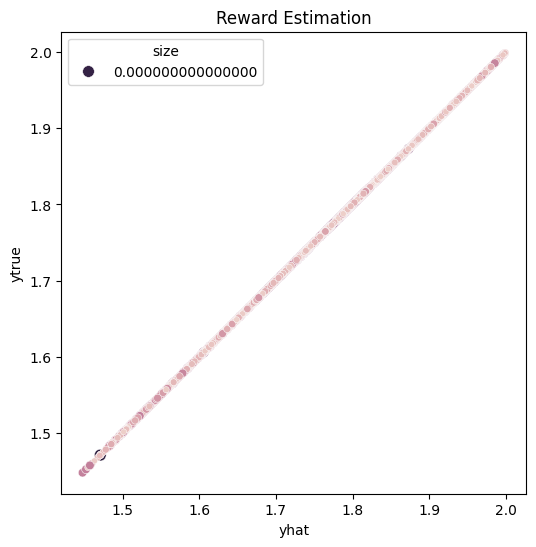

In [21]:
%%time
ge_env = GEMObsPreproc(gem.make("Finite-CC-PMSM-v0", reward_function=reward_fn))

ge_buffer, ge_sol = solve_rwe(
    ge_env,
    num_steps=NUM_STEPS,
    sample_size=SAMPLE_SIZE,
    delay=2,
)

errors = []
vpred = []
vtrue = []
for _ in range(10):
    ge_eval_X, ge_eval_y = proj_obs_to_rwest_vec(ge_buffer, sample_size=10_000)
    rew_yhat = np.matmul(ge_eval_X, ge_sol)
    vpred.extend(rew_yhat.tolist())
    vtrue.extend(ge_eval_y.tolist())
    error = rmse(
        v_pred=rew_yhat, 
        v_true=ge_eval_y,
        axis=0
    )
    errors.append(error)

print("Error -", "Mean:", np.mean(errors), "Max:", np.max(errors), "Min:", np.min(errors))
rwe_scatterplot(
    v_pred=np.array(vpred), 
    v_true=np.array(vtrue)
)
df_raw = pd.DataFrame({"vpred": vpred, "vtrue": vtrue, "method": "raw"})

### Scaled

In [22]:
class GEMScaleObsWrapper(gym.ObservationWrapper):
    def __init__(self, env, hash_dim: Optional[int] = None):
        super().__init__(env)
        self.hash_dim = hash_dim
        
        self.obs_space = env.observation_space
        self.num_actions = env.action_space.n
        self.hash_dim = hash_dim
        self.obs_dim = np.size(self.obs_space.high)

    def observation(self, obs: Any):
        obs_scaled_01 = (obs - self.obs_space.low) / (self.obs_space.high - self.obs_space.low)
        return obs_scaled_01

Error - Mean: 3.0257018867216032e-15 Max: 3.1437948401046164e-15 Min: 2.960471680057955e-15
CPU times: user 33.3 s, sys: 13.9 s, total: 47.1 s
Wall time: 27.5 s


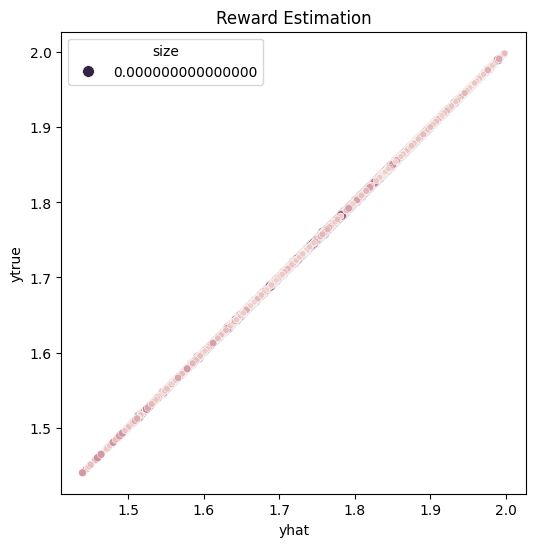

In [23]:
%%time
ge_env = GEMScaleObsWrapper(
    GEMObsPreproc(gem.make("Finite-CC-PMSM-v0", reward_function=reward_fn))
)

ge_buffer, ge_sol = solve_rwe(
    ge_env,
    num_steps=NUM_STEPS,
    sample_size=SAMPLE_SIZE,
    delay=2,
)

errors = []
vpred = []
vtrue = []
for _ in range(10):
    ge_eval_X, ge_eval_y = proj_obs_to_rwest_vec(ge_buffer, sample_size=10_000)
    rew_yhat = np.matmul(ge_eval_X, ge_sol)
    vpred.extend(rew_yhat.tolist())
    vtrue.extend(ge_eval_y.tolist())
    error = rmse(
        v_pred=rew_yhat, 
        v_true=ge_eval_y,
        axis=0
    )
    errors.append(error)

print("Error -", "Mean:", np.mean(errors), "Max:", np.max(errors), "Min:", np.min(errors))
rwe_scatterplot(
    v_pred=np.array(vpred), 
    v_true=np.array(vtrue)
)
df_scaled = pd.DataFrame({"vpred": vpred, "vtrue": vtrue, "method": "scaled"})

### Gaussian

In [24]:
class GEMGaussianMixObsWrapper(gym.ObservationWrapper):
    def __init__(self, env, param_grid, steps: int):
        super().__init__(env)
        buffer = collection_traj_data(env, steps=steps)
        self.grid_search = self.gm_proj(buffer, param_grid)
        self.estimator = self.grid_search.best_estimator_
        print("Best estimator:", self.grid_search.best_estimator_)
        self.obs_dim = self.grid_search.best_estimator_.n_components
        
        self.observation_space = gym.spaces.Box(
            low=np.zeros(shape=self.obs_dim, dtype=np.float32), 
            high=np.ones(shape=self.obs_dim, dtype=np.float32)
        )
    
    def gm_proj(self, buffer, param_grid):
        # exclude last state component
        obs = np.stack([example[2] for example in buffer])
        grid_search = model_selection.GridSearchCV(
            mixture.GaussianMixture(), param_grid=param_grid, scoring=self.gmm_bic_score
        )
        return grid_search.fit(obs)    

    def gmm_bic_score(self, estimator, X):
        """Callable to pass to GridSearchCV that will use the BIC score."""
        # Make it negative since GridSearchCV expects a score to maximize
        return -estimator.bic(X)    

    def observation(self, obs):
        # Apply to first N dimensions
        xs_batch = self.estimator.predict_proba(np.array([obs]))
        return xs_batch[0]

Best estimator: GaussianMixture(covariance_type='diag', n_components=10)
Error - Mean: 0.05002441112830153 Max: 0.05045507894264065 Min: 0.049481881628336666
CPU times: user 30min 6s, sys: 25min 5s, total: 55min 12s
Wall time: 8min 9s


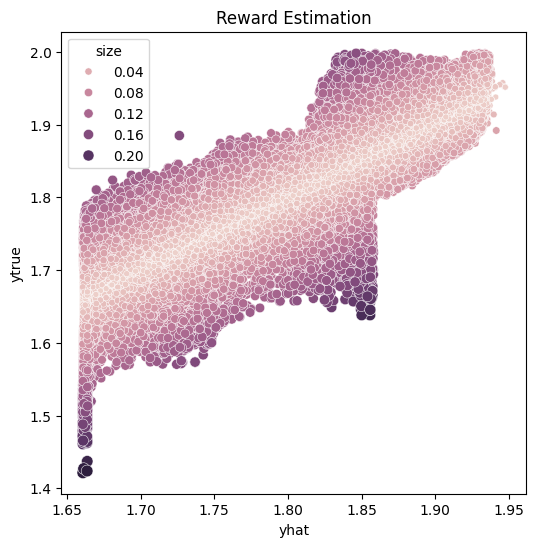

In [25]:
%%time
param_grid = {
    "n_components": range(6, 12),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

ge_env = GEMGaussianMixObsWrapper(
    GEMObsPreproc(gem.make("Finite-CC-PMSM-v0", reward_function=reward_fn)), 
    param_grid=param_grid, 
    steps=100_000,
)

ge_buffer, ge_sol = solve_rwe(
    ge_env,
    num_steps=NUM_STEPS,
    sample_size=SAMPLE_SIZE,
    delay=2,
)

errors = []
vpred = []
vtrue = []
for _ in range(10):
    ge_eval_X, ge_eval_y = proj_obs_to_rwest_vec(ge_buffer, sample_size=10_000)
    rew_yhat = np.matmul(ge_eval_X, ge_sol)
    vpred.extend(rew_yhat.tolist())
    vtrue.extend(ge_eval_y.tolist())
    error = rmse(
        v_pred=rew_yhat, 
        v_true=ge_eval_y,
        axis=0
    )
    errors.append(error)

print("Error -", "Mean:", np.mean(errors), "Max:", np.max(errors), "Min:", np.min(errors))
rwe_scatterplot(
    v_pred=np.array(vpred), 
    v_true=np.array(vtrue)
)
df_gm = pd.DataFrame({"vpred": vpred, "vtrue": vtrue, "method": "gm"})

A disdvantage of Gaussian Mixture as a projection approach is that it requires prior data to fit an estimator.
In the case of reward estimation, this same data can be used to first an estimator and then to estimate the rewards using the projected states (not what's happening above).
However, for value function approximation, this would have an extra step before value function estimation.

### Tiling

In [26]:
class GEMTileObsWrapper(gym.ObservationWrapper):
    def __init__(self, env, tiling_dim: int, num_tilings: int = None, hash_dim: Optional[int] = None):
        super().__init__(env)
        self.hash_dim = hash_dim
        self.tiles = Tiles(
                dims_min=env.observation_space.low,
                dims_max=env.observation_space.high,
                tiling_dim=tiling_dim,
                num_tilings=num_tilings
            )
        self.observation_space = gym.spaces.Box(
            low=np.zeros(shape=self.hash_dim or self.tiles.max_size, dtype=np.float64), 
            high=np.ones(shape=self.hash_dim or self.tiles.max_size, dtype=np.float64)
        )

    def observation(self, obs):
        xs = self.tiles(obs)
        if self.hash_dim:
            xs = hashtrick(xs, dim=self.hash_dim)
        return xs

In [27]:
ge_env = GEMTileObsWrapper(
    GEMObsPreproc(gem.make("Finite-CC-PMSM-v0", reward_function=reward_fn)),
    tiling_dim=4
)
ge_env.observation_space, ge_env.action_space

Num tilings 32 
 Flat dim: 131072


/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


(Box(0.0, 1.0, (131072,), float32), Discrete(8))

In [28]:
ge_env = GEMTileObsWrapper(
    GEMObsPreproc(gem.make("Finite-CC-PMSM-v0", reward_function=reward_fn)),
    tiling_dim=5
)
ge_env.observation_space

Num tilings 32 
 Flat dim: 500000


Box(0.0, 1.0, (500000,), float32)

In [29]:
ge_env = GEMTileObsWrapper(
    GEMObsPreproc(gem.make("Finite-CC-PMSM-v0", reward_function=reward_fn)),
    tiling_dim=6
)
ge_env.observation_space

Num tilings 32 
 Flat dim: 1492992


Box(0.0, 1.0, (1492992,), float32)

In [30]:
ge_env = GEMTileObsWrapper(
    GEMObsPreproc(gem.make("Finite-CC-PMSM-v0", reward_function=reward_fn)),
    tiling_dim=7
)
ge_env.observation_space

Num tilings 32 
 Flat dim: 3764768


Box(0.0, 1.0, (3764768,), float32)

In [31]:
ge_env = GEMTileObsWrapper(
    GEMObsPreproc(gem.make("Finite-CC-PMSM-v0", reward_function=reward_fn)),
    tiling_dim=8
)
ge_env.observation_space

Num tilings 32 
 Flat dim: 8388608


Box(0.0, 1.0, (8388608,), float32)

Num tilings 32 
 Flat dim: 131072
Error - Mean: 0.046643323330021115 Max: 0.047382153322537084 Min: 0.0459338526662133
CPU times: user 17min 47s, sys: 1min 47s, total: 19min 35s
Wall time: 4min 47s


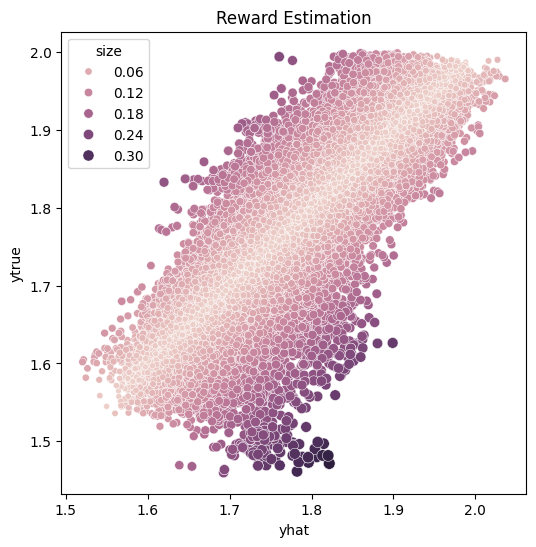

In [32]:
%%time
ge_env = GEMTileObsWrapper(
    GEMObsPreproc(gem.make("Finite-CC-PMSM-v0", reward_function=reward_fn)),
    tiling_dim=4,
    # actual size is 1024
    # will be multipled by 8 (actions)
    # so we scaled down to become 1024 after the product
    hash_dim=128
)


ge_buffer, ge_sol = solve_rwe(
    ge_env,
    num_steps=NUM_STEPS,
    sample_size=SAMPLE_SIZE,
    delay=2,
)

errors = []
vpred = []
vtrue = []
for _ in range(10):
    ge_eval_X, ge_eval_y = proj_obs_to_rwest_vec(ge_buffer, sample_size=10_000)
    rew_yhat = np.matmul(ge_eval_X, ge_sol)
    vpred.extend(rew_yhat.tolist())
    vtrue.extend(ge_eval_y.tolist())
    error = rmse(
        v_pred=rew_yhat, 
        v_true=ge_eval_y,
        axis=0
    )
    errors.append(error)

print("Error -", "Mean:", np.mean(errors), "Max:", np.max(errors), "Min:", np.min(errors))
rwe_scatterplot(
    v_pred=np.array(vpred), 
    v_true=np.array(vtrue)
)
df_tiles_4d = pd.DataFrame({"vpred": vpred, "vtrue": vtrue, "method": "tiles[D4]"})

Num tilings 32 
 Flat dim: 131072


/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Error - Mean: 0.019021557892388914 Max: 0.019256807128309586 Min: 0.01847705667714281
CPU times: user 1h 53min 17s, sys: 12min 2s, total: 2h 5min 20s
Wall time: 18min 47s


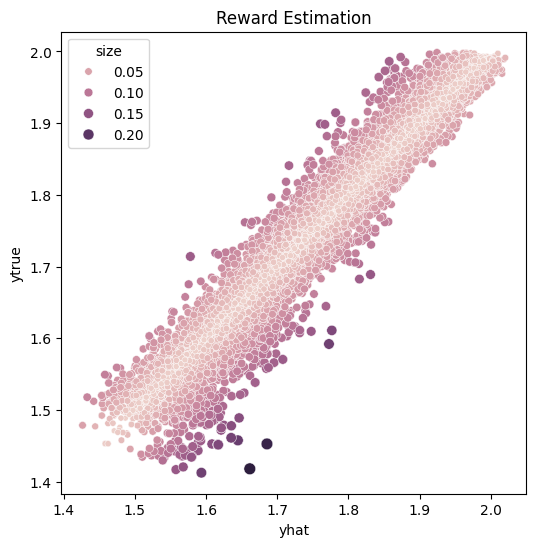

In [33]:
%%time
ge_env = GEMTileObsWrapper(
    GEMObsPreproc(gem.make("Finite-CC-PMSM-v0", reward_function=reward_fn)),
    tiling_dim=4,
    hash_dim=512
)


ge_buffer, ge_sol = solve_rwe(
    ge_env,
    num_steps=NUM_STEPS,
    sample_size=SAMPLE_SIZE,
    delay=2,
)

errors = []
vpred = []
vtrue = []
for _ in range(10):
    ge_eval_X, ge_eval_y = proj_obs_to_rwest_vec(ge_buffer, sample_size=10_000)
    rew_yhat = np.matmul(ge_eval_X, ge_sol)
    vpred.extend(rew_yhat.tolist())
    vtrue.extend(ge_eval_y.tolist())
    error = rmse(
        v_pred=rew_yhat, 
        v_true=ge_eval_y,
        axis=0
    )
    errors.append(error)

print("Error -", "Mean:", np.mean(errors), "Max:", np.max(errors), "Min:", np.min(errors))
rwe_scatterplot(
    v_pred=np.array(vpred), 
    v_true=np.array(vtrue)
)
df_tiles_8d = pd.DataFrame({"vpred": vpred, "vtrue": vtrue, "method": "tiles[D8]"})

## Conclusions

### Results Overview

In [34]:
df_results = pd.concat([
    df_raw,
    df_scaled,
    df_gm,
    df_tiles_4d,
    df_tiles_8d,
])
df_results["delta"] = df_results["vtrue"] - df_results["vpred"]

In [35]:
df_results

,vpred,vtrue,method,delta
0,1.851216,1.851216,raw,3.330669e-15
1,1.822304,1.822304,raw,1.332268e-15
2,1.584061,1.584061,raw,4.440892e-15
3,1.951196,1.951196,raw,-6.661338e-16
4,1.897716,1.897716,raw,3.996803e-15
...,...,...,...,...
99995,1.747185,1.751750,tiles[D8],4.565486e-03
99996,1.681798,1.679697,tiles[D8],-2.100987e-03
99997,1.750488,1.779847,tiles[D8],2.935870e-02
99998,1.828018,1.840045,tiles[D8],1.202694e-02


/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this war

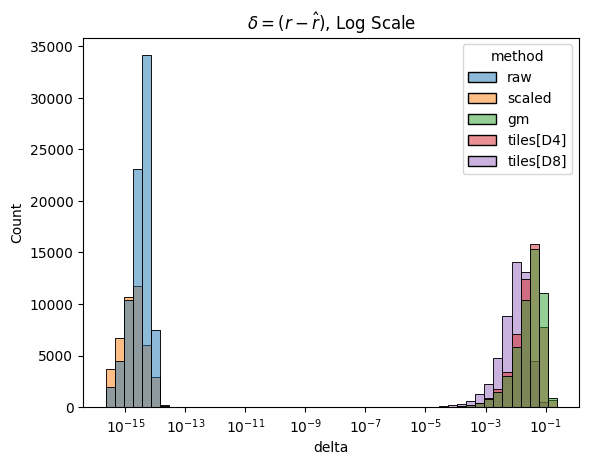

In [36]:
ax = sns.histplot(data=df_results, x="delta", hue="method", bins=50, log_scale=True)
_ = ax.set_title("$\delta = (r-\hat{r})$, Log Scale")

  - Results, by order of performance: raw or scaled > Gaussian Mixture > Tiling
  - Raw features and input scaling work equally well on the task of reward estimation
  - Most of the errors with Tiling and Gaussian Mixture can be attributed to states that violate the constraints of the problem, for which there is a high fixed penalty
    - This violation is indicated by a variable, $c \in [0, 1]$, which gets dilluted by both methods.
    - Note that we tested Tiling using the Hashing Trick, since the dimensions of the output vectors is considerably high.